# Visualization of correlation analysis for houses
Hereby the steps adopted for the correlation analysis are showed and described.

### Importing cleaned dataset
Original dataset is imported into SalesDataCleaner class before being cleaned.

In [26]:
#importing necessary libraries
from SalesDataCleaner import SalesDataCleaner
import pandas as pd
import numpy as np
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [27]:
#cleaning the dataset
url = 'https://raw.githubusercontent.com/FrancescoMariottini/project3/main/inputs/all_sales_data.csv'

sdc = SalesDataCleaner(url)

sdc.clean()

df = sdc.sales_data

df = df[df.house_is==True]

source                 int32
hyperlink             object
locality              object
postcode              object
house_is                bool
property_subtype      object
price                float64
sale                  object
rooms_number         float64
area                 float64
kitchen_has           object
furnished             object
open_fire             object
terrace               object
terrace_area         float64
garden                object
garden_area          float64
land_surface         float64
land_plot_surface    float64
facades_number       float64
swimming_pool_has     object
building_state        object
dtype: object


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Identifying and excluding numerical outliers from analysis
Extreme outliers were identified and excluded from the correlation analysis in order to have a more accurate correlation analysis.

Overview of the numerical variables in the cleaned dataset

In [28]:
df_description = df.describe(percentiles=[0.95, 0.94, 0.75, 0.5, 0.25, 0.06, 0.05], include=np.number)
print(df_description)
print(f"\n {len(df.groupby('postcode').agg([len]))} postcodes in the df")

            source         price  rooms_number         area  terrace_area  \
count  6068.000000  6.068000e+03   6068.000000  6068.000000   6068.000000   
mean      5.987146  5.555275e+05      4.037080   263.948418     13.570534   
std       0.159836  6.718471e+05      3.311046   249.444049     31.533554   
min       4.000000  2.500000e+04      0.000000     5.000000      0.000000   
5%        6.000000  1.290000e+05      2.000000   100.000000      0.000000   
6%        6.000000  1.380200e+05      2.000000   101.000000      0.000000   
25%       6.000000  2.400000e+05      3.000000   150.000000      0.000000   
50%       6.000000  3.590000e+05      4.000000   205.000000      0.000000   
75%       6.000000  5.950000e+05      5.000000   300.000000     18.000000   
94%       6.000000  1.489800e+06      7.000000   550.000000     56.000000   
95%       6.000000  1.650000e+06      7.000000   595.000000     60.000000   
max       6.000000  1.500000e+07    100.000000  8800.000000    708.000000   

Zeros can hide non-realistic (e.g. in land surface) or possible omissions (e.g. in terrace area and they are then replaced with np.nan first.
Rooms equal to zero were verified as being kots or similar.

In [29]:
columns_with_omissions = ["terrace_area", "garden_area", "land_surface", "price"]
df_cleaned= df.copy(deep=True)
for column in columns_with_omissions:
    df_cleaned[column] = df_cleaned[column].transform(lambda x: np.nan if x == 0 else x)

Outliers are defined as values belonging <ins>only</ins> to percentile <5% and >95% corresponding to double the standard deviation.

In [30]:
import pandas as pd
import numpy as np
#only numeric columns considered. Percentiles 94% and 6% were extracted to verify such condition.
print(f"{len(df)} starting values")
#outlier filters were not applied for some columns not respecting normal distribution (concentration of values only to higher values)
columns_to_be_ignored = ["terrace_area", "source", "garden_area"]
for column in df_description:
    #no filtering on terrace_area due to high variability
    if column not in columns_to_be_ignored:
        p95 = df_description.loc["95%", column]
        p94 = df_description.loc["94%", column]
        p06 = df_description.loc["6%", column]
        p05 = df_description.loc["5%", column]
        if p95 != p94:
            print(f"excluding min outliers in {column}")
            df_cleaned= df_cleaned[df_cleaned[column]<p95]
        if p05 != p06:
            df_cleaned= df_cleaned[df_cleaned[column]>p05]
            print(f"excluding  max outliers in {column}")
        print(f"{len(df_cleaned)} values remaining after excluding {column} outliers")

print(df_cleaned.describe(percentiles=[0.95, 0.94, 0.75, 0.5, 0.25, 0.06, 0.05], include=np.number))

6068 starting values
excluding min outliers in price
excluding  max outliers in price
5429 values remaining after excluding price outliers
5429 values remaining after excluding rooms_number outliers
excluding min outliers in area
excluding  max outliers in area
5029 values remaining after excluding area outliers
excluding min outliers in land_surface
4471 values remaining after excluding land_surface outliers
4471 values remaining after excluding facades_number outliers
            source         price  rooms_number         area  terrace_area  \
count  4471.000000  4.471000e+03   4471.000000  4471.000000   1697.000000   
mean      5.985238  4.370155e+05      3.850593   229.563632     34.452563   
std       0.171208  2.670507e+05      1.586873    97.658607     35.505899   
min       4.000000  1.295000e+05      0.000000   101.000000      1.000000   
5%        6.000000  1.660000e+05      2.000000   120.000000      8.000000   
6%        6.000000  1.700000e+05      2.000000   120.000000    

### Converting categorical variables and adding numerical variables
Categorical variables were analysed by assigning to them median price (target variable).

For postcode a limited number of values remained for some postcodes after removing outliers.

In [31]:
postcode_price = df_cleaned.groupby('postcode')['price'].agg([min,max,np.mean,np.median,len])
#verifying count and values per postcode
print(postcode_price.sort_values(by="median", ascending=False).head(5))
print(postcode_price.sort_values(by="mean", ascending=False).head(5))

def get_postcode_price(x):
    postcode_price_median = postcode_price.loc[x,"median"]
    return postcode_price_median

df_cleaned["postcode_price"] = df_cleaned["postcode"].apply(get_postcode_price)

                min        max          mean     median   len
postcode                                                     
2330      1350000.0  1350000.0  1.350000e+06  1350000.0   1.0
2970       925000.0  1495000.0  1.211250e+06  1212500.0   4.0
2350      1150000.0  1150000.0  1.150000e+06  1150000.0   1.0
2321      1100000.0  1100000.0  1.100000e+06  1100000.0   1.0
1000       289000.0  1500000.0  9.920357e+05   997000.0  28.0
                min        max          mean     median   len
postcode                                                     
2330      1350000.0  1350000.0  1.350000e+06  1350000.0   1.0
2970       925000.0  1495000.0  1.211250e+06  1212500.0   4.0
2350      1150000.0  1150000.0  1.150000e+06  1150000.0   1.0
2321      1100000.0  1100000.0  1.100000e+06  1100000.0   1.0
1050       340000.0  1590000.0  1.027229e+06   985000.0  47.0


For building state more values were available.

In [32]:
"""
state_price = df_cleaned.groupby('building_state')['price'].agg([min,max,np.mean,np.median,len])
#verifying count and values per status
print(postcode_price.sort_values(by="median", ascending=False).head(5))
print(postcode_price.sort_values(by="mean", ascending=False).head(5))

def get_building_state_price(x):
    state_price_median = state_price.loc[x,"median"]
    return state_price_median

df_cleaned["building_state_price"] = df_cleaned["building_state"].apply(get_building_state_price)
"""

'\nstate_price = df_cleaned.groupby(\'building_state\')[\'price\'].agg([min,max,np.mean,np.median,len])\n#verifying count and values per status\nprint(postcode_price.sort_values(by="median", ascending=False).head(5))\nprint(postcode_price.sort_values(by="mean", ascending=False).head(5))\n\ndef get_building_state_price(x):\n    state_price_median = state_price.loc[x,"median"]\n    return state_price_median\n\ndf_cleaned["building_state_price"] = df_cleaned["building_state"].apply(get_building_state_price)\n'

For subtypes more values were available too.

In [33]:
property_subtype_price = df_cleaned.groupby('property_subtype')['price'].agg([min,max,np.mean,np.median,len])
#verifying count and values per status
print(property_subtype_price.sort_values(by="median", ascending=False).head(5))
print(property_subtype_price.sort_values(by="mean", ascending=False).head(5))

def get_property_subtype_price(x):
    subtype_price_median = property_subtype_price.loc[x,"median"]
    return subtype_price_median

df_cleaned["property_subtype_price"] = df_cleaned["property_subtype"].apply(get_property_subtype_price)

                           min        max           mean    median    len
property_subtype                                                         
EXCEPTIONAL_PROPERTY  150000.0  1595000.0  736529.487179  697000.0   78.0
VILLA                 175000.0  1595000.0  621161.750842  550000.0  594.0
MANOR_HOUSE           290000.0   895000.0  561666.666667  547500.0    6.0
CASTLE                535000.0   535000.0  535000.000000  535000.0    1.0
MANSION               158000.0  1575000.0  629626.417323  529000.0  127.0
                           min        max           mean    median    len
property_subtype                                                         
EXCEPTIONAL_PROPERTY  150000.0  1595000.0  736529.487179  697000.0   78.0
MANSION               158000.0  1575000.0  629626.417323  529000.0  127.0
VILLA                 175000.0  1595000.0  621161.750842  550000.0  594.0
MANOR_HOUSE           290000.0   895000.0  561666.666667  547500.0    6.0
CASTLE                535000.0   53500

### Correlation analysis
Pearson method was used to analyse correlation

In [34]:
#first source column is removed
#facades excluded not enough values
df_cleaned.drop(columns=["source","facades_number"], inplace=True)

price                     1.000000
postcode_price            0.701602
area                      0.569832
property_subtype_price    0.383493
rooms_number              0.361876
land_surface              0.263403
terrace_area              0.139844
garden_area               0.040387
Name: price, dtype: float64


<AxesSubplot:>

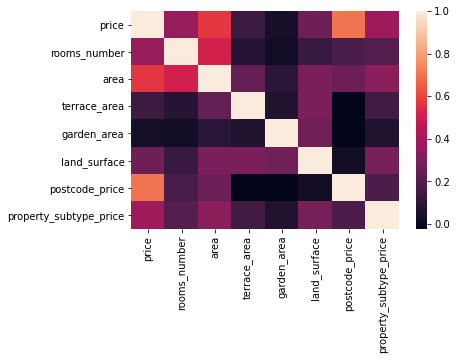

In [37]:
df_cleaned = df_cleaned.select_dtypes(include=float)
df_corr = df_cleaned.corr(method="pearson")
print(df_corr["price"].sort_values(ascending=False))
sns.heatmap(df_corr)